In [5]:
import h5py
import time
import torch
import torchvision
import matplotlib.pyplot as plt
h5py_file = h5py.File("/coc/flash7/datasets/egoplay/demo_data.h5", "r+")

In [6]:
def scatter_3d(points, angle=0):
    """
        make a 3d scatter plot for points of shape (Time, 3) where 3 is x,y,z
        color the points by time, make the axis interactive
    """
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points[:,0], points[:,1], points[:,2], c=range(points.shape[0]))
    #rotate the 3d plot
    ax.view_init(15, angle)
    # plt.show()


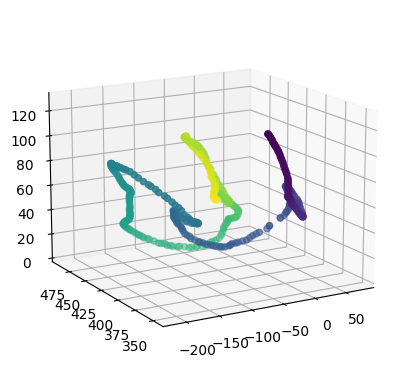

In [7]:
h5py_file["demo_0/obs/ee_pose"].shape
scatter_3d(h5py_file["demo_0/obs/ee_pose"][0:500, :3], -120)

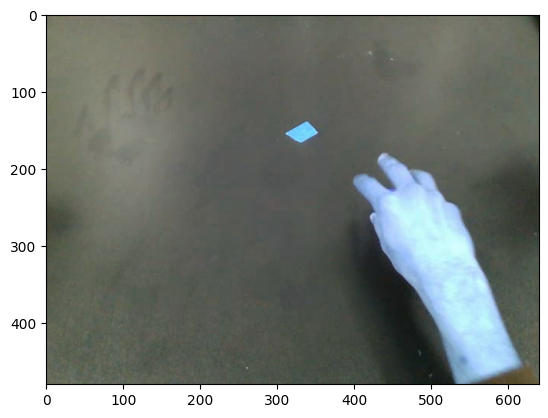

In [8]:
plt.imshow(h5py_file["demo_0/obs/Front_image_1"][150])

In [9]:
h5py_file["demo_0/obs/Front_image_1"].shape
vid = torch.from_numpy(h5py_file["demo_0/obs/Front_image_1"][0:500])
torchvision.io.write_video("hand_traj.mp4", vid, fps=30)

In [3]:
import cv2
img = cv2.imread("out.ppm")

imread_('out.ppm'): can't read data: OpenCV(4.6.0) /io/opencv/modules/imgcodecs/src/bitstrm.cpp:110: error: (-2:Unspecified error) Unexpected end of input stream in function 'readBlock'



## Calibration Data

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.spatial.transform import Rotation as Rot
calib = h5py.File("/coc/flash7/skareer6/calibrate_samples/robomimic.hdf5", "r+")

In [2]:
demo = calib["demo1"]

[-0.00153398 -0.9664079   1.1903691   0.00153398 -0.2899224  -0.00153398]
<KeysViewHDF5 ['ee_pose', 'front_img_1', 'front_img_2', 'gripper_position', 'joint_positions', 'joint_vel', 'wrist_img_1']>


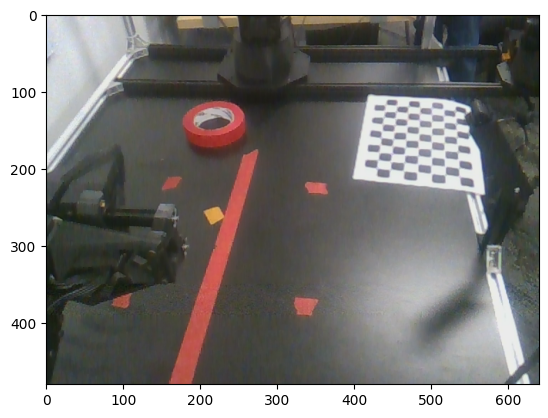

In [3]:
t=0
# x (forward pos), y(left pos), z (up pos)
# print(demo["obs/front_img_1"][t].shape)
print(demo["obs/joint_positions"][t])
print(demo["obs"].keys())

plt.imshow(demo["obs/front_img_1"][t])

In [4]:
# if given quat use Rot.from_quat asmatrix()
R_cam_base = np.array([
    [ 0.144, -0.598, 0.789],
    [-0.978, 0.036, 0.206],
    [-0.152, -0.801, -0.579]
])
Tr_cam_base = np.array([[-0.017, -0.202, 0.491]])
# Tr_cam_base = np.array([[0.012, -0.254, 0.534]]) #measured


T_cam_base = np.concatenate([R_cam_base, Tr_cam_base.T], axis=1)
T_cam_base = np.concatenate([T_cam_base, np.array([[0, 0, 0, 1]])], axis=0)
print("Full Transform: ", T_cam_base)
# T_cam_base = np.linalg.inv(T_cam_base)

#Our calibrated intrinsics
# intrinsics = np.array([
#     [625.579822, 0.000000, 302.919366, 0.000000],
#     [0.000000, 624.831489, 248.344753, 0.000000],
#     [0.000000, 0.000000, 1.000000, 0.000000]
# ])

#Internal realsense numbers
intrinsics = np.array([
    [616.0, 0.0, 313.4, 0.0],
    [0.0, 615.7, 236.7, 0.0],
    [0.0, 0.0, 1.0, 0.0]
])


Full Transform:  [[ 0.144 -0.598  0.789 -0.017]
 [-0.978  0.036  0.206 -0.202]
 [-0.152 -0.801 -0.579  0.491]
 [ 0.     0.     0.     1.   ]]


In [5]:
def ee_pose_to_cam_pixels(ee_pose_base):
    ee_pose_base = np.concatenate([ee_pose_base, np.array([1])], axis=0)
    print("3d pos in base frame: ", ee_pose_base)

    ee_pose_grip_cam = np.linalg.inv(T_cam_base) @ ee_pose_base
    print("3d pos in cam frame: ", ee_pose_grip_cam)

    px_val = intrinsics @ ee_pose_grip_cam
    px_val = px_val / px_val[2]
    print("2d pos cam frame: ", px_val)

    return px_val

In [6]:
def draw_dot_on_frame(frame_num, pixel_val):
    frame = demo["obs/front_img_1"][frame_num]
    frame = frame.copy()
    frame = cv2.circle(frame, (int(pixel_val[0]), int(pixel_val[1])), 5, (0, 255, 0), -1)
    plt.imshow(frame)
    plt.show()

3d pos in base frame:  [ 0.35833236 -0.17932137  0.18936851  1.        ]
3d pos in cam frame:  [0.07760897 0.01822989 0.47535887 1.        ]
2d pos cam frame:  [413.97059348 260.31194073   1.        ]
[413.97059348 260.31194073   1.        ]


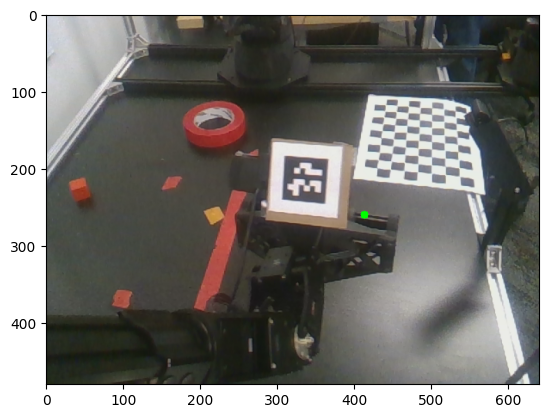

In [17]:
T = 200
px_val = ee_pose_to_cam_pixels(demo["obs/ee_pose"][T][:3])
print(px_val)
draw_dot_on_frame(T, px_val)

3d pos in base frame:  [ 0.37 -0.14 -0.02  1.  ]
3d pos in cam frame:  [0.09453244 0.18389648 0.63628036 1.        ]
2d pos cam frame:  [404.91937494 414.64838399   1.        ]
[404.91937494 414.64838399   1.        ]


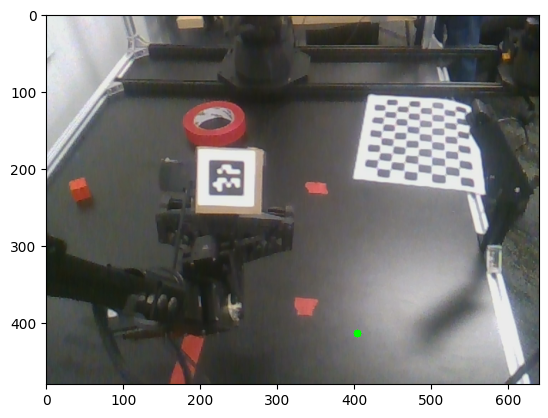

In [38]:
T = 500
px_val = ee_pose_to_cam_pixels(np.array([0.37, -0.14, -0.02]))
print(px_val)
draw_dot_on_frame(T, px_val)

# IK ground up

In [1]:
import h5py
import matplotlib.pyplot as plt

In [2]:
file = h5py.File("/coc/flash7/skareer6/episode_0.hdf5", "r+")
file["observations/qpos"].shape
joint_poses = file["observations/qpos"][0:700]

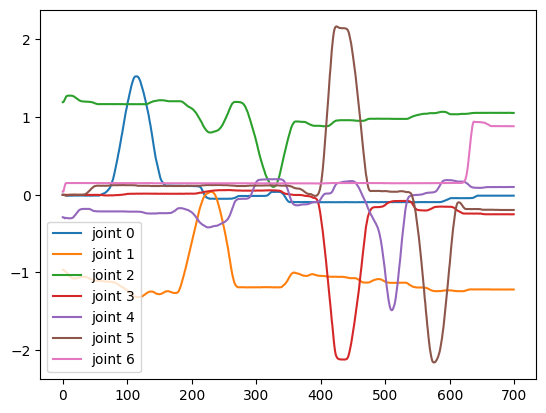

In [5]:
# plt.plot(joint_poses)
#plot each joint in joint_poses and label it in the legend
joint_poses = joint_poses[:, 0:7]
for i in range(joint_poses.shape[1]):
    plt.plot(joint_poses[:,i], label="joint {}".format(i))
plt.legend()
plt.show()

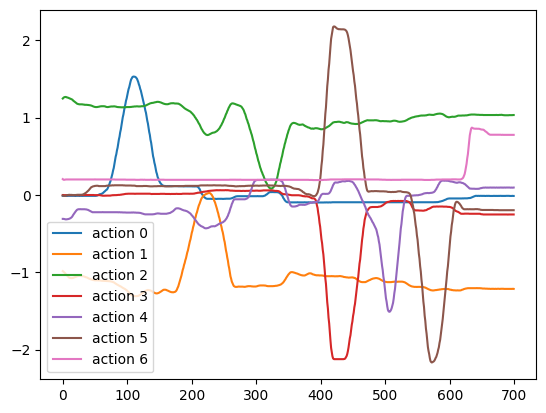

In [6]:
# plot same for actions
actions = file["action"][:, :7]
for i in range(actions.shape[1]):
    plt.plot(actions[:,i], label="action {}".format(i))
plt.legend()
plt.show()

## Next check the poses for 2 known positions

In [28]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from modern_robotics import FKinSpace

In [29]:
file = h5py.File("/coc/flash7/skareer6/touch_points.hdf5", "r+")

In [30]:
M = np.array([[1.0, 0.0, 0.0, 0.536494],
    [0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.42705],
    [0.0, 0.0, 0.0, 1.0]])

Slist = np.array([[0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, -0.12705, 0.0, 0.0],
    [0.0, 1.0, 0.0, -0.42705, 0.0, 0.05955],
    [1.0, 0.0, 0.0, 0.0, 0.42705, 0.0],
    [0.0, 1.0, 0.0, -0.42705, 0.0, 0.35955],
    [1.0, 0.0, 0.0, 0.0, 0.42705, 0.0]]).T

In [31]:
joint_poses = file["observations/qpos"][0:700]

[[ 0.72 -0.12  0.69  0.34]
 [ 0.13  0.99  0.04  0.09]
 [-0.68  0.06  0.73  0.03]
 [ 0.    0.    0.    1.  ]]


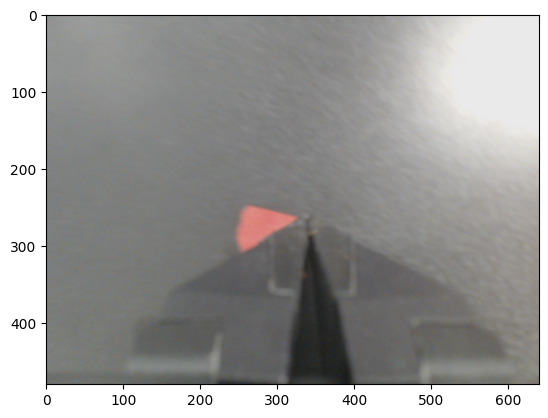

In [54]:
T = 200
# print joint pos and show camera image
joint_poses = joint_poses[:, 0:7]
# print(joint_poses[T])
plt.imshow(file["observations/images/cam_left_wrist"][T])
trans = FKinSpace(M, Slist, joint_poses[T][:6])
print(trans.round(2))